# pyTorch scatch from 0 to 1 w/ ResNet
Pytorch進行圖像分類 - 手刻ResNet-18和Torchvision匯入

1. Residual Network <br>
為深度學習最常用的網路架構之一，為何愷明（Kaiming He）在2015年提出的論文"Deep Residual Learning for Image Recognition"。google citation: 173984 (2023/07/24)，這樣的citation超可怕的，就知道它有多重要了。<br>

2. Torchvision匯入常見的模型。<br>

### 卷積神經網路計算公式 (超級重要)


#### 1. 卷積層

對於卷積層，輸出特徵圖的大小 \(W_{out}\), \(H_{out}\) 可以透過以下公式計算：

- $$W_{out} = \left\lfloor \frac{W_{in} - K + 2P}{S} \right\rfloor + 1$$
- $$H_{out} = \left\lfloor \frac{H_{in} - K + 2P}{S} \right\rfloor + 1$$

其中：

- \(K\) 是卷積核的大小（假設為正方形，所以寬度和高度相同）。
- \(P\) 是邊緣填充的數量（Padding）。
- \(S\) 是卷積的步長（Stride）。
- \(W_{in}\), \(H_{in}\) 是輸入特徵圖的寬度和高度。
- \(W_{out}\), \(H_{out}\) 是輸出特徵圖的寬度和高度。

#### 2. 池化層

對於池化層，公式與卷積層類似，但通常沒有填充（\(P=0\)），並且池化操作通常有一個固定的窗口大小 \(F\) 和步長 \(S\)。因此，輸出的大小 \(W_{out}\), \(H_{out}\) 可以透過以下公式計算：

- $$W_{out} = \left\lfloor \frac{W_{in} - F}{S} \right\rfloor + 1$$
- $$H_{out} = \left\lfloor \frac{H_{in} - F}{S} \right\rfloor + 1$$

其中：

- \(F\) 是池化窗口的大小。
- \(S\) 是池化的步長。
- \(W_{in}\), \(H_{in}\) 是輸入特徵圖的寬度和高度。
- \(W_{out}\), \(H_{out}\) 是輸出特徵圖的寬度和高度。

## 1. Residual Network

這篇我們不特別講它的重要性，我們教大家如何利用Pytorch手刻一個ResNet-18的模型架構。<br>
但我們要先大家知道ResNet-18長什麼樣，見下圖。

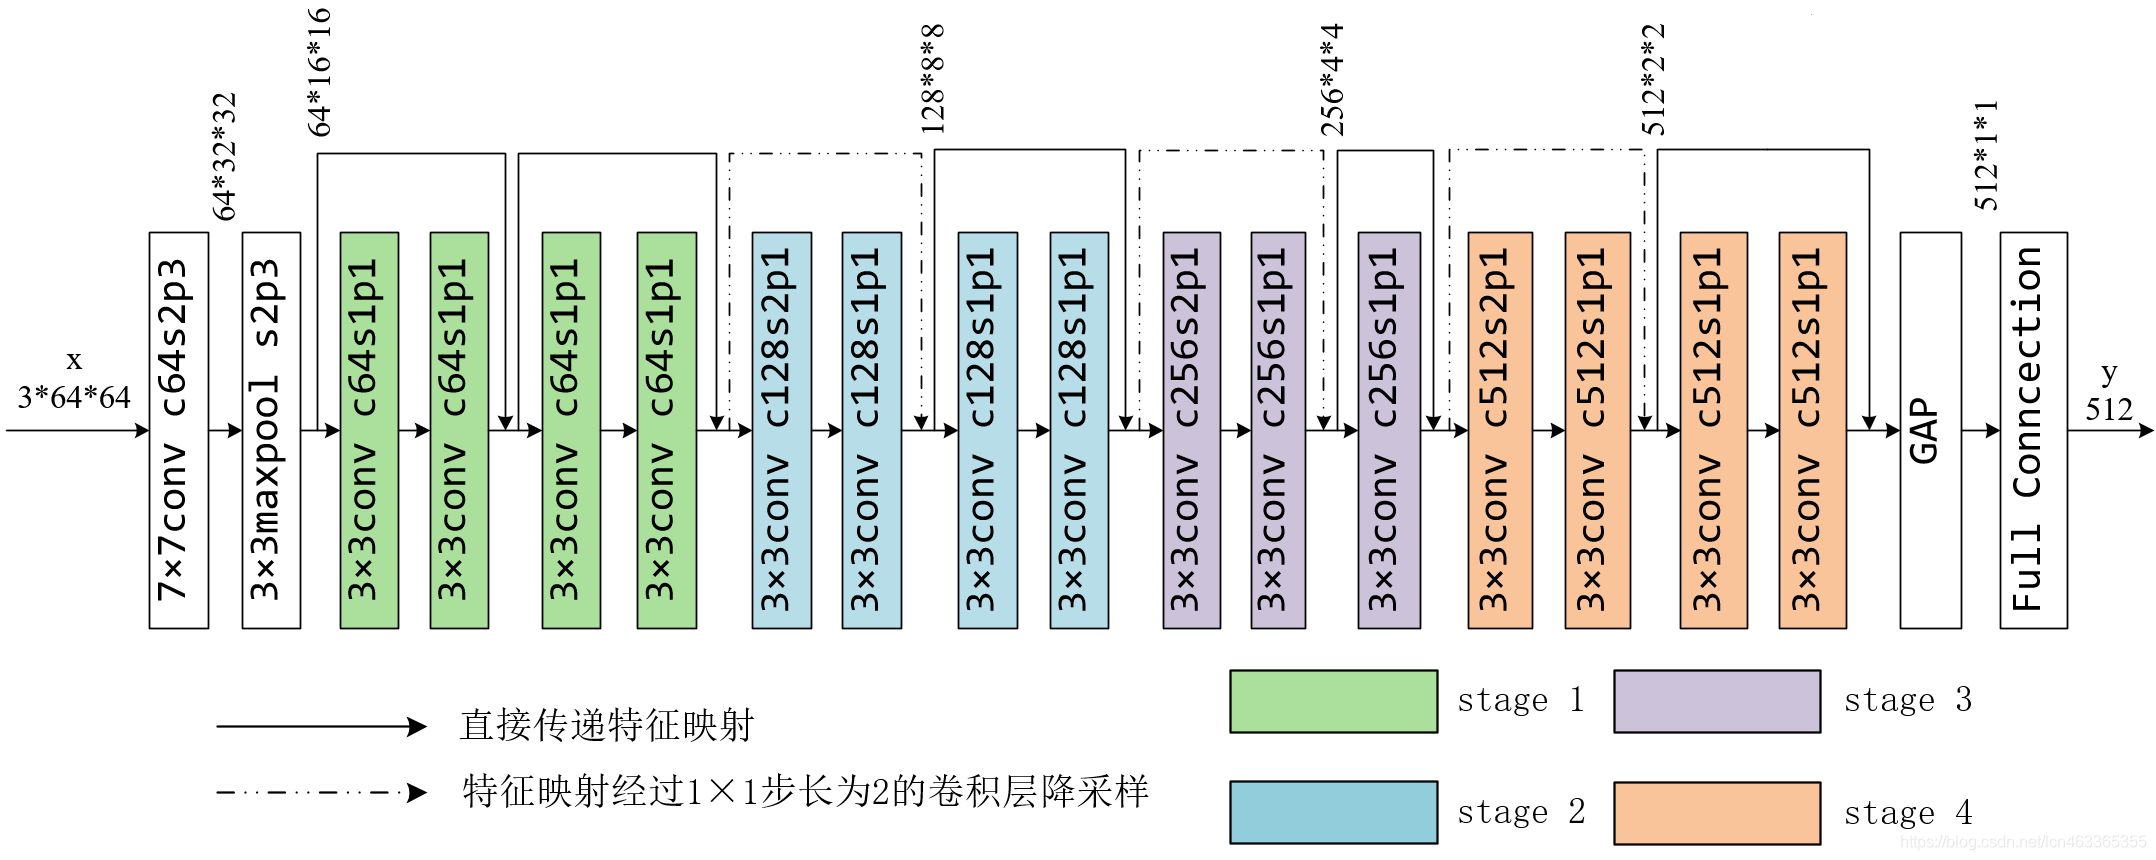
圖片來源: https://blog.csdn.net/lcn463365355/article/details/92846776


本篇ResNet寫法採一行一行手刻的方式進行，但這樣的方式更容易讓大家進行模型理解和學習。<br>

採用 conv $1 \times 1$ (stride=2) 的方式進行低採樣(將特徵圖片解析降低的過程)。
[參考](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)




In [1]:
import  torch
import torch.nn as nn
from torch import Tensor


In [9]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)    # padding=dilation, dilation=dilation

# 降解析
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)   # padding=dilation, dilation=dilation


In [49]:
class resnet18(nn.Module):
    def __init__(self, num_classes=10):
        super(resnet18, self).__init__()

        '''
            1. 建立元件
            2. 初始化權重
        '''

        # image channel 比例
        channel_ration = 1

        # layer 0   
        out = int(64 * channel_ration) # 為了減低計算量，將輸出通道數減少
        self.conv1 = nn.Conv2d(3, out, kernel_size=7, stride=2, padding=3,bias=False)      
        self.bn1 = nn.BatchNorm2d(out)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layer 1
        # layer 1.1 resedule block 1
        out = int(64 * channel_ration)
        self.l1_r1_conv1 = conv3x3(out, out, 1) 
        self.l1_r1_bn1 = nn.BatchNorm2d(out)
        self.l1_relu = nn.ReLU(inplace=True)    
        self.l1_r1_conv2 = conv3x3(out, out)
        self.l1_r1_bn2 = nn.BatchNorm2d(out)

        # layer 1.2 resedule block 2
        self.l1_r2_conv1 = conv3x3(out, out, 1) 
        self.l1_r2_bn1 = nn.BatchNorm2d(out)
        self.l1_relu = nn.ReLU(inplace=True)    
        self.l1_r2_conv2 = conv3x3(out, out)
        self.l1_r2_bn2 = nn.BatchNorm2d(out)
        

        # layer 2
        # layer 2.1 resedule block 1
        in_ = int(64 * channel_ration)
        out = int(128 * channel_ration)
        self.downsample2 = nn.Sequential(conv1x1(in_, out, 2),
                                         nn.BatchNorm2d(out),) # 特徵映射經過1*1卷積，步長為2，輸出通道數為out，降解析
        
        self.l2_r1_conv1 = conv3x3(in_, out, 2)
        self.l2_r1_bn1 = nn.BatchNorm2d(out)
        self.l2_relu = nn.ReLU(inplace=True)
        self.l2_r1_conv2 = conv3x3(out, out)
        self.l2_r1_bn2 = nn.BatchNorm2d(out)

        # layer 2.2 resedule block 2
        self.l2_r2_conv1 = conv3x3(out, out, 1)
        self.l2_r2_bn1 = nn.BatchNorm2d(out)
        self.l2_relu = nn.ReLU(inplace=True)
        self.l2_r2_conv2 = conv3x3(out, out)
        self.l2_r2_bn2 = nn.BatchNorm2d(out)
  
        # layer 3
        # layer 3.1 resedule block 1
        in_ = int(128 * channel_ration)
        out = int(256 * channel_ration)
        self.downsample3 = nn.Sequential(conv1x1(in_, out, 2),
                                         nn.BatchNorm2d(out),) # 特徵映射經過1*1卷積，步長為2，輸出通道數為out，降解析

        self.l3_r1_conv1 = conv3x3(in_, out, 2)
        self.l3_r1_bn1 = nn.BatchNorm2d(out)
        self.l3_relu = nn.ReLU(inplace=True)
        self.l3_r1_conv2 = conv3x3(out, out)
        self.l3_r1_bn2 = nn.BatchNorm2d(out)

        # layer 3.2 resedule block 2
        self.l3_r2_conv1 = conv3x3(out, out, 1)
        self.l3_r2_bn1 = nn.BatchNorm2d(out)
        self.l3_relu = nn.ReLU(inplace=True)
        self.l3_r2_conv2 = conv3x3(out, out)
        self.l3_r2_bn2 = nn.BatchNorm2d(out)

        # layer 4
        # layer 4.1 resedule block 1
        in_ = int(256 * channel_ration)
        out = int(512 * channel_ration)
        self.downsample4 = nn.Sequential(conv1x1(in_, out, 2),
                                         nn.BatchNorm2d(out),) # 特徵映射經過1*1卷積，步長為2，輸出通道數為out，降解析

        self.l4_r1_conv1 = conv3x3(in_, out, 2)
        self.l4_r1_bn1 = nn.BatchNorm2d(out)
        self.l4_relu = nn.ReLU(inplace=True)
        self.l4_r1_conv2 = conv3x3(out, out)
        self.l4_r1_bn2 = nn.BatchNorm2d(out)

        # layer 4.2 resedule block 2
        self.l4_r2_conv1 = conv3x3(out, out, 1)
        self.l4_r2_bn1 = nn.BatchNorm2d(out)
        self.l4_relu = nn.ReLU(inplace=True)
        self.l4_r2_conv2 = conv3x3(out, out)
        self.l4_r2_bn2 = nn.BatchNorm2d(out)


        # final layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out , num_classes)

        # 初始化權重
        for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):    
        # layer 0 (scale: 1 -> 1/4)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # layer 1 (scale: 1/4 -> 1/4)
        identity11 = x
        x = self.l1_r1_conv1(x)
        x = self.l1_r1_bn1(x)
        x = self.l1_relu(x)
        x = self.l1_r1_conv2(x)
        x = self.l1_r1_bn2(x)
        x += identity11
        x = self.l1_relu(x)

        identity12 = x
        x = self.l1_r2_conv1(x)
        x = self.l1_r2_bn1(x)
        x = self.l1_relu(x)
        x = self.l1_r2_conv2(x)
        x = self.l1_r2_bn2(x)
        x += identity12
        x = self.l1_relu(x)

       # layer 2 (scale: 1/4 -> 1/8)
        identity21 = self.downsample2(x)
        x = self.l2_r1_conv1(x)
        x = self.l2_r1_bn1(x)
        x = self.l2_relu(x)
        x = self.l2_r1_conv2(x)
        x = self.l2_r1_bn2(x)
        x += identity21
        x = self.l2_relu(x)

        identity22 = x
        x = self.l2_r2_conv1(x)
        x = self.l2_r2_bn1(x)
        x = self.l2_relu(x)
        x = self.l2_r2_conv2(x)
        x = self.l2_r2_bn2(x)
        x += identity22
        x = self.l2_relu(x)

       # layer 3 (scale: 1/8 -> 1/16)
        identity31 = self.downsample3(x)
        x = self.l3_r1_conv1(x)
        x = self.l3_r1_bn1(x)
        x = self.l3_relu(x)
        x = self.l3_r1_conv2(x)
        x = self.l3_r1_bn2(x)
        x += identity31
        x = self.l3_relu(x)
        
        identity32 = x
        x = self.l3_r2_conv1(x)
        x = self.l3_r2_bn1(x)
        x = self.l3_relu(x)
        x = self.l3_r2_conv2(x)
        x = self.l3_r2_bn2(x)
        x += identity32
        x = self.l3_relu(x)

        # layer 4 (scale: 1/16 -> 1/32)
        identity41 = self.downsample4(x)
        x = self.l4_r1_conv1(x)
        x = self.l4_r1_bn1(x)
        x = self.l4_relu(x)
        x = self.l4_r1_conv2(x)
        x = self.l4_r1_bn2(x)
        x += identity41
        x = self.l4_relu(x)
        
        identity42 = x
        x = self.l4_r2_conv1(x)
        x = self.l4_r2_bn1(x)
        x = self.l4_relu(x)
        x = self.l4_r2_conv2(x)
        x = self.l4_r2_bn2(x)
        x += identity42
        x = self.l4_relu(x) # b * 512 * 7 * 7
        

        # final layers
        x = self.avgpool(x) #  b * 512 * 1 * 1
        x = x.view(x.size(0), -1) # b * 512
        x = self.fc(x) # input: b * in_channel; output: b * out_channel
        return x






In [54]:
restnet18 = resnet18(num_classes=10)
print(restnet18)
dummy_input = torch.randn(1, 3, 128, 128)
out = restnet18(dummy_input)
print(out.shape)


resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (l1_r1_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (l1_r1_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1_relu): ReLU(inplace=True)
  (l1_r1_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (l1_r1_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1_r2_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (l1_r2_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1_r2_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

### 模型可視化可以利用Netron的網頁來觀察
Netron: https://netron.app/
<br>
https://github.com/lutzroeder/netron



In [ ]:
# Export the model to ONNX
dummy_input = torch.randn(1, 3, 128, 128)
torch.onnx.export(
    model=restnet18,                        # Your model instance
    args=dummy_input,                     # Model's input tensor (or a tuple for multiple inputs)
    f='./onnx/restnet18.onnx',              # Path to save the ONNX model
    opset_version=11,                     # ONNX opset version to use
    input_names=['input'],                # Optionally define the input tensor name
    output_names=['output'],              # Optionally define the output tensor name
)

### 導入實際資料 CIFAR-10 

>1. 設定hyperparameter: batch size，epoch size etc..<br>

>2. 宣告 dataset和dataloader<br>

>3. 宣告模型: restnet18<br>

>4. Loss Function: 因為為分類任務採用Cross Entropy<br>

>5. optimizer: torch.optim.SGD<br>
scheduler: MultiStepLR


### 資料處理

In [55]:
from torchvision import datasets, transforms

use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

mytransform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# (0.4914, 0.4822, 0.4465) => mean for CIFAR10
# (0.2023, 0.1994, 0.2010) => std for CIFAR10


#1. 設定hyperparameter: batch size，epoch size等等
n_batch=1024
total_epoch = 100
milestones=[30,60,90,120]

# 2.宣告 dataset和dataloader
# training data
dataset_train = datasets.CIFAR10(root='./dataset', train=True,  download=True, transform=mytransform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=n_batch, num_workers=0, shuffle=True)
# testing data
testset = datasets.CIFAR10(root='./dataset/CIFAR10/', train=False, download=True, transform=mytransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=n_batch, shuffle=False)

#3. 宣告模型: resnet18
model = resnet18(num_classes=10).to(device)

#4. Loss Function: 因為為分類任務採用Cross Entropy
criterion = torch.nn.CrossEntropyLoss().to(device)

#5. optimizer: torch.optim.SGD
#   scheduler: MultiStepLR
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5) # gamma learning rate decay



cpu


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset\cifar-10-python.tar.gz to ./dataset


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/CIFAR10/cifar-10-python.tar.gz to ./dataset/CIFAR10/


### 訓練計畫 (訓練 -> 推論)

In [56]:
def evalmodel(model, testloader, loss):
    model.eval() # 設定eval模式
    test_loss_cnn = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            output_cnn = model(data)
            loss_cnn = loss(output_cnn,target)  
            test_loss_cnn += loss_cnn
            _, predicted = torch.max(output_cnn.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        # the class with the highest energy is what we choose as prediction

    test_loss_cnn /= len(testloader.dataset)
    acc = 100 * correct / total
    return test_loss_cnn.cpu().detach().numpy(), acc

def train(model, optimizer,dataloader_train, testloader, loss, total_epoch, scheduler):
    log_loss_train=[]
    log_loss_test=[]
    
    for epoch in range(total_epoch):
        # train
        model.train() # 設定train模式
        train_loss_cnn = 0
        for batch_idx, (data, target) in enumerate(dataloader_train):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # 清空梯度
            output_cnn = model(data) # 輸入data，得到output
            loss_cnn = loss(output_cnn,target)  # 計算loss
            train_loss_cnn += loss_cnn # 累加loss
            loss_cnn.backward() # 反向傳播
            optimizer.step() # 更新權重
        train_loss_cnn /= len(dataloader_train.dataset)
        scheduler.step()
    
        if epoch % 10 == 0:
            train_loss, train_acc= evalmodel(model, dataloader_train, loss)
            test_loss, test_acc= evalmodel(model, testloader, loss)
            
            log_loss_train.append(train_loss)
            log_loss_test.append(test_loss)
            print('learning rate:{}'.format(scheduler.get_last_lr()[0]))
            print('CNN[epoch: [{}/{}], Average loss (Train):{:.5f}, Average loss (test):{:.5f}, acc(train):{:.4f}, acc(test):{:.4f}'.format(
                epoch+1, total_epoch, train_loss, test_loss, train_acc, test_acc))
                      
    print('CNN[epoch: [{}/{}], Average loss (Train):{:.5f}, Average loss (test):{:.5f}, acc(train):{:.4f}, acc(test):{:.4f}'.format(
                epoch+1, total_epoch, train_loss, test_loss, train_acc, test_acc))
    print('training done.')
    return log_loss_train, log_loss_test




### 模型訓練

In [57]:
print('*'*50)
print('Training....')
loss_log_train, loss_log_test = train(model, optimizer, 
                                      dataloader_train, testloader, 
                                      criterion, total_epoch=total_epoch, scheduler=scheduler)




**************************************************
Training....


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_log_train)
plt.plot(loss_log_test,'r')
plt.legend(['train','test'])
plt.title('Loss')
plt.show()

### 模型儲存

In [ ]:
torch.save(model.state_dict(), 'resnet18_model.pth') # save model


## load model
model = resnet18(num_classes=10)  # Create an instance of the model
model.load_state_dict(torch.load('resnet18_model.pth'))  # Load the saved model state_dict
model.eval()  # Set the model to evaluation mode


### 小結論

模型如果越複雜，資料的變異不夠，越容易產生overfitting的問題。<br>

先不管training tricks的方式來避免overfitting的問題。<br>

最簡單的方式就是使用Data Augumention進行資料增強的方式，增加資料的變異避免overfitting的問題發生。<br>

## Torchvision官方模型匯入常見的模型


請參閱:https://pytorch.org/vision/stable/models.html

只要用下列範例程式:在參數帶入<br>
```pretrained = True```:則會下載訓練好ImageNet資料庫的預模型，帶入。<br>
```pretrained=False```:只幫你建立好模型架構，權重是隨機產生的。<br>

In [3]:
import torch
import torchvision.models as models

restnet18_modelzoo = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=False)
# squeezenet = models.squeezenet1_0(pretrained=False)
# vgg16 = models.vgg16(pretrained=False)
# densenet = models.densenet161(pretrained=False)
# inception = models.inception_v3(pretrained=False)
# googlenet = models.googlenet(pretrained=False)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=False)
# mobilenet_v2 = models.mobilenet_v2(pretrained=True)
# mobilenet_v3_large = models.mobilenet_v3_large(pretrained=False)
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=False)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=False)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=False)
# mnasnet = models.mnasnet1_0(pretrained=False)

# print(restnet18_modelzoo)
dummy_input = torch.randn(1, 3, 224, 224)
out = restnet18_modelzoo(dummy_input)
torch.onnx.export(restnet18_modelzoo, dummy_input, "restnet18_modelzoo.onnx", opset_version=11)


C:\Users\xdxd2\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\xdxd2\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\xdxd2/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 預訓練模型加載並訓練

In [ ]:
n_batch=256
total_epoch = 20
milestones=[10,15]
restnet18_modelzoo = models.resnet18(pretrained=True)
optimizer = torch.optim.SGD(restnet18_modelzoo.parameters(), lr=0.001,momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
loss_log_rain, loss_log_test = train(model, optimizer, dataloader_train, testloader, criterion, total_epoch=total_epoch, scheduler=scheduler)



## 預訓練模型加載並訓練 (修改預測類別數量)

In [ ]:
import torch
import torchvision.models as models
import torch.optim as optim

# 加载预训练的 ResNet18 模型
resnet18_model = models.resnet18(pretrained=True)

# 修改全连接层以匹配目标类别数
num_ftrs = resnet18_model.fc.in_features  # 获取fc层的输入特征数量
num_classes = 100  # 假设我们的目标是100个类别
resnet18_model.fc = torch.nn.Linear(num_ftrs, num_classes)  # 用新的fc层替换

# 更新优化器以包含新的参数
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

# 接下来，您可以继续使用您的模型训练流程
